# ToF Filtering to Maximize Sensitivity
Numerical verification(using simulation data) of my optimization derivation. The formula states that sensitivity can be maximized if we maximize the following term wrt the integration limits
$$
\frac{\int I(L) |log(R(L))|}{\int I(L)} dL
$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from inverse_modelling_tfo.tools.name_decoder import decode_extended_filename
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2, get_mu_a
from tfo_sensitivity.data import load_raw
from tfo_sensitivity.tof import ToF, two_pointer_discrete_optimize

plt.style.use('seaborn')

maternal_wall_thickness, uterus_thickness, wave_int = 6, 5, 1
raw_sim_data_path = load_raw(maternal_wall_thickness, uterus_thickness, wave_int)
raw_sim_data = pd.read_pickle(raw_sim_data_path)
# Create SDD column!
raw_sim_data['SDD'] = raw_sim_data['X'] - 100
all_sdd = raw_sim_data['SDD'].unique()

In [2]:
MATERNAL_Hb = 11.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.50
FETAL_Hb = 11.0
DELTA = 1
SDD_index = 2

data_table = pd.DataFrame(columns=['Saturation', 'Derivative', 'SDD', 'Type'])
all_c = np.arange(0.1, 1.5, 0.1)
all_fetal_sat = np.arange(0.1, 0.65, 0.2)
base_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2

modified_mu_map_base = base_mu_map.copy()
modified_mu_map_base[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
modified_mu_map_base[4] = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int)

modified_mu_map_increased = base_mu_map.copy()
modified_mu_map_increased[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
modified_mu_map_increased[4] = get_mu_a(FETAL_SAT, FETAL_Hb + DELTA, wave_int)

data_table = pd.DataFrame(columns=['Derivative', 'SDD', 'I'])

filtered_photon_data  = (raw_sim_data[raw_sim_data["SDD"] == all_sdd[SDD_index]]).copy()

In [33]:
# Comments: Setting to 0.1e-9 makes taking only the last point the optimum, however making it 0.07e-9 makes the whole range the optimum!
# This is an optimization error. Like there's a small hiccup at the left edge which prevents the optimizer from finding the optimum. 
# But even in this case, the optimum is at the bottom right edge of the 2D plot (which means again taking the largest time bin only)
TIME_RESOLUTION = 0.07e-9
lower_intensity_bound = 1e-15
tof_base = ToF(filtered_photon_data, TIME_RESOLUTION, modified_mu_map_base, SDD_index, lower_intensity_bound)
tof_increased = ToF(filtered_photon_data, TIME_RESOLUTION, modified_mu_map_increased, SDD_index, lower_intensity_bound)

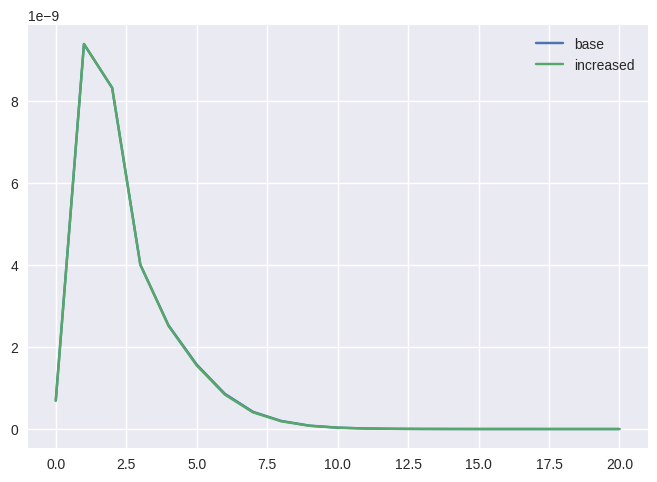

In [34]:
plt.plot(tof_base.data, label='base')
plt.plot(tof_increased.data, label='increased')
plt.xlabel('Time Bin')
plt.ylabel('Input Normalized Intensity')
plt.legend()

In [35]:
RL = tof_base / tof_increased 
numerator = tof_base * RL
numerator = np.abs(np.log(numerator.data))
denominator = tof_base.data

target_func = lambda left, right: numerator.iloc[left: right + 1].sum() / denominator.iloc[left: right + 1].sum()

left, right, optimum = two_pointer_discrete_optimize(target_func, 0, len(tof_base.data) - 1, "max")
print("Data Length", len(numerator))
print(left, right, optimum)

Data Length 21
0 20 18513878904.444695


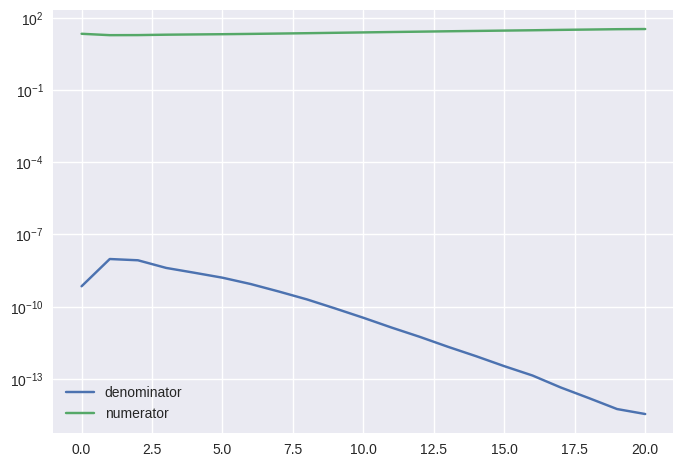

In [36]:
plt.plot(denominator, label='denominator')
plt.plot(numerator, label='numerator')
plt.yscale('log')
plt.legend()

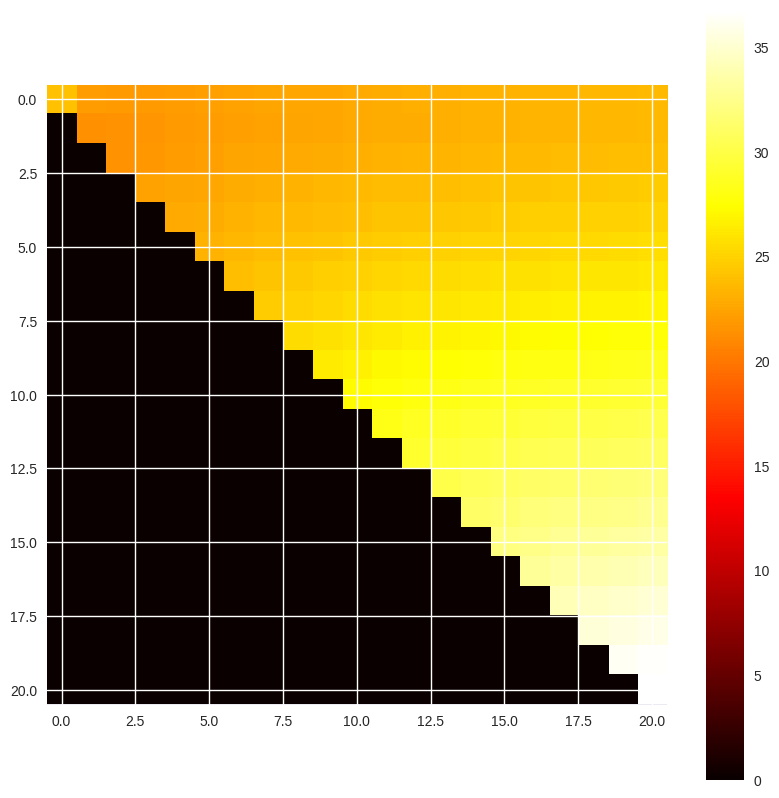

In [37]:
# Brute Force Optimization
plt.figure(figsize=(10, 10))
target_func_matrix = np.ones((len(tof_base.data), len(tof_base.data)))
for i in range(len(tof_base.data)):
    for j in range(i, len(tof_base.data)):
        target_func_matrix[i, j] = target_func(i, j)
target_func_matrix = np.abs(np.log(target_func_matrix))
plt.imshow(target_func_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()